### MNIST con PCA y Catboost como clasificador

En la prueba con la librería de catboost, la funcionalidad de "feature importance" mostró que hay muchos atributos que no aportan poco o nada de información al modelo. Por lo que se realizará una prueba de reducción de dimensionalidad con PCA y ver si se mantiene un porcentaje alto de presición. Además se reducirá el tiempo de entrenamiento.



In [69]:
# Importamos las librerías básicas
import numpy as np 
import pandas as pd 
import random as rn

# librarias de visualización
import pydotplus
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

Si no esta instalado CatBoost se debe realizar  **pip install catboost**
Cargamos los datos de MNIST en dataframes de pandas

In [2]:
path = './data'

In [137]:
train_df= pd.read_csv(path + '/mnist_train.csv')
test_df= pd.read_csv(path + '/mnist_test.csv')

X_train = train_df.iloc[:,1:]
y_train = train_df.iloc[:,0]

X_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]

# set de datos completo

_X_full_ = pd.concat([train_df,test_df])
_X_ = _X_full_.iloc[:,1:]
_y_ = _X_full_.iloc[:,0]

Visualizamos como estan distribuidos los registros del dataset para cada etiqueta

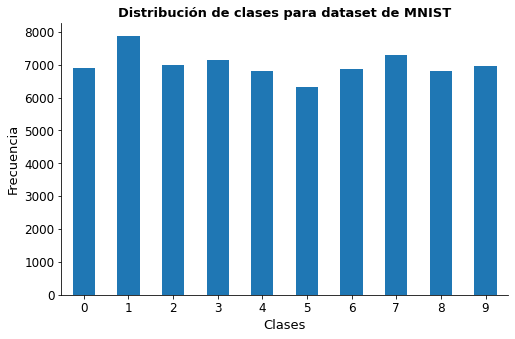

In [138]:
# Visualize target distribution
_X_full_['label'].value_counts().sort_index().plot(kind='bar', figsize=(8, 5), rot=0)
plt.title('Distribución de clases para dataset de MNIST', fontsize=13, weight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Clases', fontsize=13)
plt.ylabel('Frecuencia', fontsize=13)
sns.despine()
plt.show()

### Funciones

In [141]:
def show_images(num_images):
    """
    Muestra en una tabla de imágenes del set de datos
    """
    
    if num_images % 10 == 0 and num_images <= 100:
        for digit_num in range(0,num_images): 
            plt.subplot(num_images/10,10,digit_num+1) #create subplots
            mat_data = _X_.iloc[digit_num].values.reshape(28,28)  #reshape images
            plt.imshow(mat_data) #plot the data
            plt.xticks([]) #removes numbered labels on x-axis
            plt.yticks([]) #removes numbered labels on y-axis
            

In [142]:
def show_images_by_digit(digit_to_see):
    
    """
    Muestra en una tabla las primeras 50 imágenes del set de datos según la etiqueta indicada como parámetro
    """
        
    if digit_to_see in list(range(10)):
        indices = np.where(_y_ == digit_to_see) # pull indices for num of interest
        for digit_num in range(0,50): 
            plt.subplot(5,10, digit_num+1) #create subplots
            #reshape images
            mat_data = _X_.iloc[indices[0][digit_num]].values.reshape(28,28)
            plt.imshow(mat_data) #plot the data
            plt.xticks([]) #removes numbered labels on x-axis
            plt.yticks([]) #removes numbered labels on y-axis


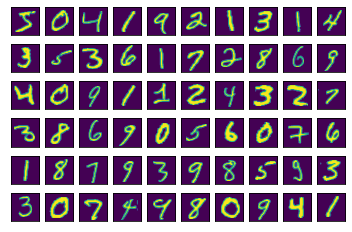

In [143]:
show_images(60)

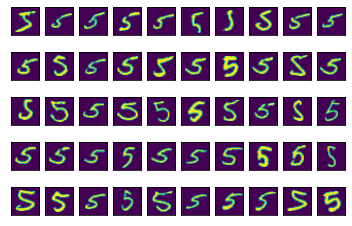

In [144]:
show_images_by_digit(5)

In [9]:
def get_pca(n_components, data):
    
    """
    Retorna el objeto PCA y la matriz de datos con la cantidad de componentes que se indica como parametro en
    n_components
    """
    
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [26]:
def plot_components(X, y):
    
    """
    Grafica las etiquetas con colores para el set de datos del parametro X
    """
    
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(10, 6))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), 
                 color=plt.cm.Set1(y[i]), 
                 fontdict={'size': 15})

    plt.xticks([]), plt.yticks([]), plt.ylim([-0.1,1.1]), plt.xlim([-0.1,1.1])


In [37]:
def scree_plot(pca):
    
    """
    Grafica el porcentaje de variación por componente 
    """
    
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(round(vals[i]*100,1))[:3])), (ind[i]+0.2, vals[i]), 
                    va="bottom", 
                    ha="center", 
                    fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=1, length=6)
 
    ax.set_xlabel("PCA")
    ax.set_ylabel("Varianza Explicada en (%)")
    plt.title('Varianza Explicada por componente')

In [149]:
def fit_classifier(X, y, **kwargs):

    """
    Retorna el modelo de clasificación entrenado y la presición.
    Se utiliza la opción de dividir los datos en set de entrenamiento y evaluacion.
    
    Se dejará el archivo de "mnist_test.csv" para validar por separado
    
    Parametros:
    print_conf_matrix_output = (bool) indica si muestra la matriz de confusión
    iterations =  cantidad de iteraciones o ensambles de arboles del modelo  (default = 1000)
    early_stopping_rounds = overfitting detector (default 30)
    
    """
    _print_conf_matrix_output = kwargs.get('print_conf_matrix_output', True)
    _iterations = kwargs.get('iterations', 1000)
    _early_stopping_rounds = kwargs.get('early_stopping_rounds', 30)
    
    
    
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y, 
                                                        test_size=0.30, 
                                                        random_state=42)
    
    # Se instnacia el clasificador con 2500 I
    
    model = CatBoostClassifier(
        iterations=_iterations,
        early_stopping_rounds= _early_stopping_rounds, #overfitting detector
        random_seed=42, )

    model.fit(X_train_clf,y_train_clf, 
              verbose=50,
              plot=False, 
              eval_set=(X_test_clf, y_test_clf), 
             )

    y_preds = model.predict(X_test_clf)

    acc = accuracy_score(y_test_clf, y_preds)
    
    print('Input Shape: {}'.format(X_train_clf.shape))
    print('Accuracy: {:2.2%}'.format(acc))
    print("Cant. árboles: " + str(model.tree_count_))
        
        
    if _print_conf_matrix_output == True:    
        
        #mat = confusion_matrix(y_test_clf, y_preds)
        #sns.heatmap(mat, annot=True, linewidths=.6)
        disp = plot_confusion_matrix(model, X_test, y_test)
        disp.figure_.suptitle("Matríz de Confusión ")
        plt.show()

    return model, acc

Learning rate set to 0.28237
0:	learn: 1.5508310	test: 1.5358801	best: 1.5358801 (0)	total: 2.02s	remaining: 3m 19s
50:	learn: 0.1643354	test: 0.1876469	best: 0.1876469 (50)	total: 1m 37s	remaining: 1m 33s
99:	learn: 0.1304571	test: 0.1581641	best: 0.1581595 (98)	total: 3m 4s	remaining: 0us

bestTest = 0.1581594557
bestIteration = 98

Shrink model to first 99 iterations.
Input Shape: (59500, 784)
Accuracy: 95.47%
Cant. árboles: 99


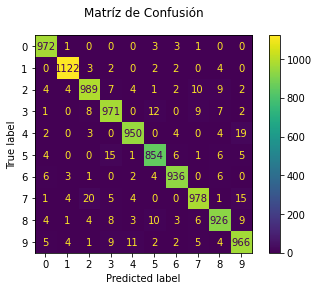

(<catboost.core.CatBoostClassifier at 0x7f4aba89c588>, 0.9546666666666667)

In [148]:
# Entrenamos el clasificador con todos los atributos del set de datos
# 100 iteraciones son muy pocas, pero sirve para el ejemplo siguiente

fit_classifier(_X_, _y_, iterations=100)

Con pocas iteraciones se logra un **95%** de presición

Provamos que tan bueno sería el modelo si usamos 2 componentes

Learning rate set to 0.116716
0:	learn: 2.1488467	test: 2.1477926	best: 2.1477926 (0)	total: 40.7ms	remaining: 40.7s
50:	learn: 1.6281776	test: 1.6367446	best: 1.6367446 (50)	total: 1.71s	remaining: 31.7s
100:	learn: 1.6138282	test: 1.6282603	best: 1.6282603 (100)	total: 3.64s	remaining: 32.4s
150:	learn: 1.6060206	test: 1.6270820	best: 1.6269849 (145)	total: 5.66s	remaining: 31.8s
200:	learn: 1.5997531	test: 1.6269769	best: 1.6267893 (172)	total: 7.44s	remaining: 29.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.626789283
bestIteration = 172

Shrink model to first 173 iterations.
Input Shape: (49000, 2)
Accuracy: 37.40%
Cant. árboles: 173


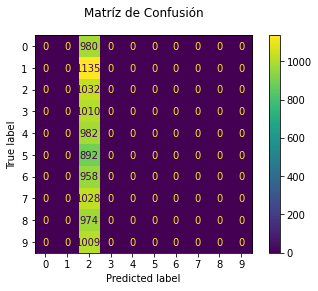

In [150]:
# llamamos a la funcion que retorna el objeto pca y la matriz de datos con la cantidad de componentes indicadas
pca, X_pca = get_pca(2, _X_)
# entrenamos el clasificador con los datos de prueba transformados a N componentes
fit_classifier(X_pca, _y_, early_stopping_rounds=50);

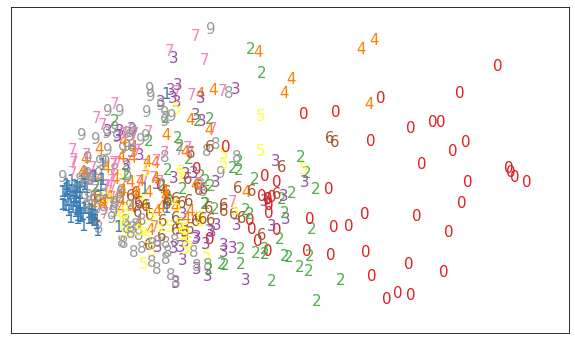

In [151]:
# graficamos los primero 500 registros transformados con PCA y 2 componentes
plot_components(X_pca[:500], _y_[:500])

Verficamos con 40 componentes que tan bueno sería le modelo

In [152]:
acc_list, pc_list = [], []
for pc in range(2,35):
    pca, X_pca = get_pca(pc, X_train)
    model, acc = fit_classifier(X_pca, y_train, print_conf_matrix_output=False);
    acc_list.append(acc)
    pc_list.append(pc)

Learning rate set to 0.116357
0:	learn: 2.1486274	test: 2.1491606	best: 2.1491606 (0)	total: 67.5ms	remaining: 1m 7s
50:	learn: 1.6402786	test: 1.6511496	best: 1.6511496 (50)	total: 1.89s	remaining: 35.2s
100:	learn: 1.6246928	test: 1.6420116	best: 1.6419585 (99)	total: 3.36s	remaining: 29.9s
150:	learn: 1.6160881	test: 1.6406195	best: 1.6406195 (150)	total: 5.04s	remaining: 28.3s
200:	learn: 1.6093364	test: 1.6408622	best: 1.6404862 (182)	total: 6.75s	remaining: 26.8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 1.640486177
bestIteration = 182

Shrink model to first 183 iterations.
Input Shape: (42000, 2)
Accuracy: 36.56%
Cant. árboles: 183
Learning rate set to 0.116357
0:	learn: 2.0524658	test: 2.0531775	best: 2.0531775 (0)	total: 43.6ms	remaining: 43.6s
50:	learn: 1.1603429	test: 1.1724391	best: 1.1724391 (50)	total: 1.89s	remaining: 35.2s
100:	learn: 1.1221103	test: 1.1425515	best: 1.1425515 (100)	total: 3.76s	remaining: 33.5s
150:	learn: 1.1059095	test: 1.1336

300:	learn: 0.2863889	test: 0.3539623	best: 0.3539623 (300)	total: 15.7s	remaining: 36.5s
350:	learn: 0.2729131	test: 0.3478399	best: 0.3478399 (350)	total: 18.3s	remaining: 33.8s
400:	learn: 0.2606108	test: 0.3425869	best: 0.3425869 (400)	total: 20.8s	remaining: 31.1s
450:	learn: 0.2502045	test: 0.3386238	best: 0.3386238 (450)	total: 23.4s	remaining: 28.5s
500:	learn: 0.2397690	test: 0.3351693	best: 0.3351693 (500)	total: 26s	remaining: 25.9s
550:	learn: 0.2311508	test: 0.3325115	best: 0.3325115 (550)	total: 28.6s	remaining: 23.3s
600:	learn: 0.2225565	test: 0.3305962	best: 0.3305962 (600)	total: 31.2s	remaining: 20.7s
650:	learn: 0.2142481	test: 0.3291932	best: 0.3291932 (650)	total: 33.8s	remaining: 18.1s
700:	learn: 0.2072648	test: 0.3280046	best: 0.3279891 (699)	total: 36.4s	remaining: 15.5s
750:	learn: 0.2004461	test: 0.3267538	best: 0.3267538 (750)	total: 39s	remaining: 12.9s
800:	learn: 0.1945429	test: 0.3258542	best: 0.3258542 (800)	total: 41.5s	remaining: 10.3s
850:	learn: 0.

350:	learn: 0.1842641	test: 0.2498734	best: 0.2498734 (350)	total: 23.1s	remaining: 42.7s
400:	learn: 0.1721175	test: 0.2429909	best: 0.2429909 (400)	total: 26.7s	remaining: 39.9s
450:	learn: 0.1605913	test: 0.2372494	best: 0.2372494 (450)	total: 29.9s	remaining: 36.4s
500:	learn: 0.1518789	test: 0.2330774	best: 0.2330774 (500)	total: 33.1s	remaining: 32.9s
550:	learn: 0.1431731	test: 0.2285285	best: 0.2285285 (550)	total: 36.3s	remaining: 29.6s
600:	learn: 0.1348405	test: 0.2253063	best: 0.2253063 (600)	total: 39.4s	remaining: 26.2s
650:	learn: 0.1278633	test: 0.2221773	best: 0.2221773 (650)	total: 42.6s	remaining: 22.8s
700:	learn: 0.1219035	test: 0.2199396	best: 0.2199396 (700)	total: 45.7s	remaining: 19.5s
750:	learn: 0.1149891	test: 0.2169641	best: 0.2169641 (750)	total: 48.8s	remaining: 16.2s
800:	learn: 0.1089977	test: 0.2149516	best: 0.2149516 (800)	total: 51.9s	remaining: 12.9s
850:	learn: 0.1041024	test: 0.2132532	best: 0.2132532 (850)	total: 55.1s	remaining: 9.64s
900:	learn

450:	learn: 0.1207624	test: 0.1865536	best: 0.1865536 (450)	total: 34.2s	remaining: 41.6s
500:	learn: 0.1109837	test: 0.1810830	best: 0.1810830 (500)	total: 38s	remaining: 37.8s
550:	learn: 0.1033185	test: 0.1769703	best: 0.1769703 (550)	total: 41.7s	remaining: 34s
600:	learn: 0.0968097	test: 0.1737057	best: 0.1737057 (600)	total: 45.4s	remaining: 30.1s
650:	learn: 0.0903820	test: 0.1706105	best: 0.1706105 (650)	total: 49.2s	remaining: 26.4s
700:	learn: 0.0849221	test: 0.1679566	best: 0.1679566 (700)	total: 52.9s	remaining: 22.6s
750:	learn: 0.0799599	test: 0.1655461	best: 0.1655461 (750)	total: 56.6s	remaining: 18.8s
800:	learn: 0.0752625	test: 0.1632159	best: 0.1632159 (800)	total: 1m	remaining: 15s
850:	learn: 0.0710151	test: 0.1616600	best: 0.1616600 (850)	total: 1m 4s	remaining: 11.2s
900:	learn: 0.0667900	test: 0.1599145	best: 0.1599145 (900)	total: 1m 7s	remaining: 7.45s
950:	learn: 0.0632356	test: 0.1587134	best: 0.1587134 (950)	total: 1m 11s	remaining: 3.69s
999:	learn: 0.0602

550:	learn: 0.0933707	test: 0.1637311	best: 0.1637311 (550)	total: 48.3s	remaining: 39.4s
600:	learn: 0.0866480	test: 0.1600469	best: 0.1600469 (600)	total: 52.7s	remaining: 35s
650:	learn: 0.0802951	test: 0.1568753	best: 0.1568753 (650)	total: 57s	remaining: 30.6s
700:	learn: 0.0750786	test: 0.1545258	best: 0.1545258 (700)	total: 1m 1s	remaining: 26.2s
750:	learn: 0.0700785	test: 0.1521860	best: 0.1521860 (750)	total: 1m 5s	remaining: 21.8s
800:	learn: 0.0656230	test: 0.1502774	best: 0.1502774 (800)	total: 1m 10s	remaining: 17.4s
850:	learn: 0.0612145	test: 0.1482662	best: 0.1482662 (850)	total: 1m 14s	remaining: 13s
900:	learn: 0.0573302	test: 0.1464260	best: 0.1464260 (900)	total: 1m 18s	remaining: 8.65s
950:	learn: 0.0538949	test: 0.1448774	best: 0.1448774 (950)	total: 1m 23s	remaining: 4.28s
999:	learn: 0.0509651	test: 0.1434486	best: 0.1434486 (999)	total: 1m 27s	remaining: 0us

bestTest = 0.1434486189
bestIteration = 999

Input Shape: (42000, 20)
Accuracy: 95.58%
Cant. árboles: 

650:	learn: 0.0753882	test: 0.1515433	best: 0.1515433 (650)	total: 1m 9s	remaining: 37.1s
700:	learn: 0.0700102	test: 0.1490842	best: 0.1490842 (700)	total: 1m 15s	remaining: 32s
750:	learn: 0.0649609	test: 0.1467132	best: 0.1467132 (750)	total: 1m 21s	remaining: 26.9s
800:	learn: 0.0603358	test: 0.1442688	best: 0.1442688 (800)	total: 1m 27s	remaining: 21.6s
850:	learn: 0.0564620	test: 0.1426678	best: 0.1426678 (850)	total: 1m 33s	remaining: 16.3s
900:	learn: 0.0524818	test: 0.1408895	best: 0.1408895 (900)	total: 1m 39s	remaining: 10.9s
950:	learn: 0.0489695	test: 0.1392910	best: 0.1392910 (950)	total: 1m 44s	remaining: 5.41s
999:	learn: 0.0459016	test: 0.1377988	best: 0.1377988 (999)	total: 1m 50s	remaining: 0us

bestTest = 0.1377988498
bestIteration = 999

Input Shape: (42000, 24)
Accuracy: 95.61%
Cant. árboles: 1000
Learning rate set to 0.116357
0:	learn: 1.9310686	test: 1.9329572	best: 1.9329572 (0)	total: 199ms	remaining: 3m 18s
50:	learn: 0.3971428	test: 0.4115085	best: 0.4115085

700:	learn: 0.0627678	test: 0.1406621	best: 0.1406621 (700)	total: 1m 33s	remaining: 39.8s
750:	learn: 0.0582792	test: 0.1382015	best: 0.1382015 (750)	total: 1m 40s	remaining: 33.5s
800:	learn: 0.0539950	test: 0.1360722	best: 0.1360722 (800)	total: 1m 47s	remaining: 26.7s
850:	learn: 0.0505446	test: 0.1341771	best: 0.1341771 (850)	total: 1m 54s	remaining: 20s
900:	learn: 0.0470507	test: 0.1323480	best: 0.1323480 (900)	total: 2m 1s	remaining: 13.3s
950:	learn: 0.0438440	test: 0.1308826	best: 0.1308826 (950)	total: 2m 7s	remaining: 6.58s
999:	learn: 0.0410081	test: 0.1295043	best: 0.1295043 (999)	total: 2m 14s	remaining: 0us

bestTest = 0.1295043188
bestIteration = 999

Input Shape: (42000, 28)
Accuracy: 95.86%
Cant. árboles: 1000
Learning rate set to 0.116357
0:	learn: 1.9321016	test: 1.9333514	best: 1.9333514 (0)	total: 179ms	remaining: 2m 58s
50:	learn: 0.3974095	test: 0.4126839	best: 0.4126839 (50)	total: 7.41s	remaining: 2m 17s
100:	learn: 0.2500213	test: 0.2771137	best: 0.2771137 (

750:	learn: 0.0555580	test: 0.1343566	best: 0.1343566 (750)	total: 1m 33s	remaining: 31.1s
800:	learn: 0.0513246	test: 0.1323784	best: 0.1323784 (800)	total: 1m 40s	remaining: 24.9s
850:	learn: 0.0478104	test: 0.1304449	best: 0.1304449 (850)	total: 1m 46s	remaining: 18.6s
900:	learn: 0.0445270	test: 0.1286814	best: 0.1286814 (900)	total: 1m 52s	remaining: 12.4s
950:	learn: 0.0412105	test: 0.1270010	best: 0.1270010 (950)	total: 1m 58s	remaining: 6.12s
999:	learn: 0.0387189	test: 0.1256878	best: 0.1256878 (999)	total: 2m 4s	remaining: 0us

bestTest = 0.1256877646
bestIteration = 999

Input Shape: (42000, 32)
Accuracy: 96.13%
Cant. árboles: 1000
Learning rate set to 0.116357
0:	learn: 1.9252449	test: 1.9256351	best: 1.9256351 (0)	total: 189ms	remaining: 3m 8s
50:	learn: 0.3954235	test: 0.4092125	best: 0.4092125 (50)	total: 6.8s	remaining: 2m 6s
100:	learn: 0.2517811	test: 0.2790908	best: 0.2790908 (100)	total: 13.5s	remaining: 1m 59s
150:	learn: 0.1932353	test: 0.2312198	best: 0.2312198 (

**Con 35 componentes se tiene una presición de 96%**

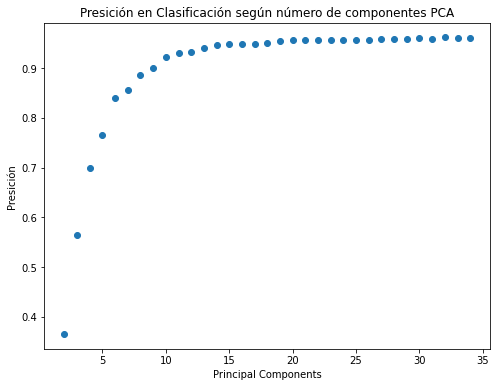

In [153]:
plt.figure(figsize=[8,6])
plt.scatter(pc_list, acc_list)
plt.title('Presición en Clasificación según número de componentes PCA')
plt.xlabel('Principal Components')
plt.ylabel('Presición');

In [155]:
# 96% con 32 componentes
np.max(acc_list), pc_list[np.where(acc_list == np.max(acc_list))[0][0]]

(0.9613333333333334, 32)

Graficamos el porcente de variacion que tiene cada componente y el acumulado

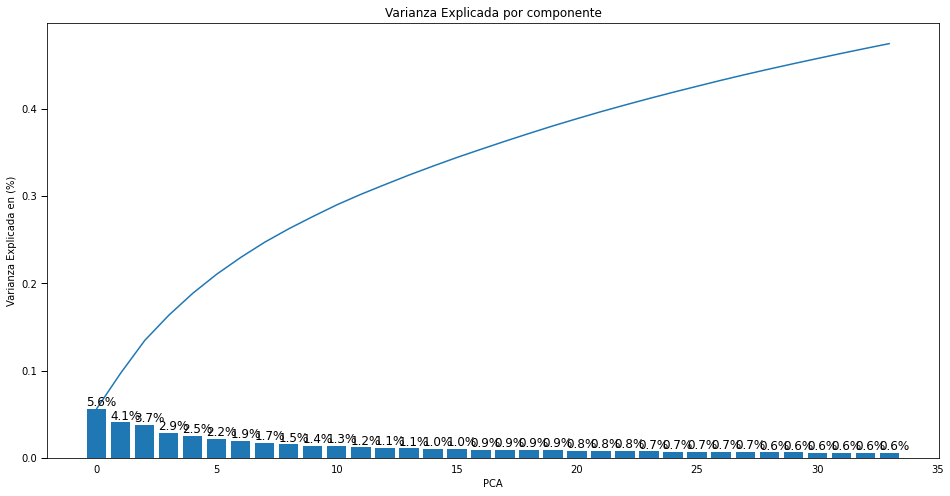

In [156]:
scree_plot(pca)

**Genero una matriz de datos con 55 componentes y evaluo el resultado. Se utilizarán 6000 iteraciones**

In [157]:
pca, X_pca = get_pca(55, _X_)

In [159]:
model, _ = fit_classifier(X_pca,_y_ , iterations = 6000, early_stopping_rounds=50, print_conf_matrix_output=False)

Learning rate set to 0.058868
0:	learn: 2.1000071	test: 2.0994476	best: 2.0994476 (0)	total: 281ms	remaining: 28m 4s
50:	learn: 0.6173503	test: 0.6279966	best: 0.6279966 (50)	total: 12s	remaining: 23m 14s
100:	learn: 0.3908514	test: 0.4082781	best: 0.4082781 (100)	total: 23.5s	remaining: 22m 51s
150:	learn: 0.2914109	test: 0.3157170	best: 0.3157170 (150)	total: 35s	remaining: 22m 35s
200:	learn: 0.2389874	test: 0.2685067	best: 0.2685067 (200)	total: 46.3s	remaining: 22m 15s
250:	learn: 0.2057048	test: 0.2393184	best: 0.2393184 (250)	total: 57.4s	remaining: 21m 54s
300:	learn: 0.1826926	test: 0.2200922	best: 0.2200922 (300)	total: 1m 8s	remaining: 21m 35s
350:	learn: 0.1659383	test: 0.2064031	best: 0.2064031 (350)	total: 1m 23s	remaining: 22m 28s
400:	learn: 0.1525724	test: 0.1961207	best: 0.1961207 (400)	total: 1m 38s	remaining: 22m 53s
450:	learn: 0.1414459	test: 0.1877410	best: 0.1877410 (450)	total: 1m 50s	remaining: 22m 44s
500:	learn: 0.1317295	test: 0.1803098	best: 0.1803098 (500

4350:	learn: 0.0095836	test: 0.1026084	best: 0.1026084 (4350)	total: 18m 34s	remaining: 7m 2s
4400:	learn: 0.0094114	test: 0.1025161	best: 0.1025161 (4400)	total: 18m 46s	remaining: 6m 49s
4450:	learn: 0.0092214	test: 0.1024002	best: 0.1024002 (4450)	total: 18m 59s	remaining: 6m 36s
4500:	learn: 0.0090285	test: 0.1022863	best: 0.1022863 (4500)	total: 19m 12s	remaining: 6m 23s
4550:	learn: 0.0088781	test: 0.1022278	best: 0.1022242 (4537)	total: 19m 25s	remaining: 6m 11s
4600:	learn: 0.0087062	test: 0.1021475	best: 0.1021416 (4595)	total: 19m 38s	remaining: 5m 58s
4650:	learn: 0.0085566	test: 0.1020550	best: 0.1020550 (4650)	total: 19m 51s	remaining: 5m 45s
4700:	learn: 0.0084002	test: 0.1019870	best: 0.1019830 (4694)	total: 20m 4s	remaining: 5m 32s
4750:	learn: 0.0082735	test: 0.1019360	best: 0.1019360 (4750)	total: 20m 17s	remaining: 5m 20s
4800:	learn: 0.0081151	test: 0.1018813	best: 0.1018665 (4784)	total: 20m 30s	remaining: 5m 7s
4850:	learn: 0.0079739	test: 0.1017802	best: 0.101772

In [ ]:
model.tree_count_

**Con 55 componentes se puede alcanzar una presición de 97%. Esto reduce el tiempo de entrenamiento y el tamaño del modelo. Gracias a la opción de "feature importance" que ofrece catbooost, se visualizó que muchos features no aportaban mucho al modelo y se podían omitir usando alguna técnica de reducción de dimensionalidad.**
